<p style="font-family: Arials; line-height: 2; font-size: 24px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #10e02c;"> <a href="#part0" style="color:#d910e0; text-decoration:none;">Multiple Comparisons</a></p>

<p style="font-family: Bahnschrift Condensed"> Проблема множинних порівнянь полягає в тому, що стандартні статистичні процедури можуть ввести в оману, коли дослідники проводять багато перевірок гіпотез. Коли дослідник проводить більше однієї перевірки гіпотези (або набору тісно пов'язаних гіпотез), велика ймовірність того, що якийсь висновок здасться «значним» навіть якщо нічого не відбувається. Класичні тести гіпотез оцінюють статистичну значущість, обчислюючи ймовірність при нульовій гіпотезі отримання оцінок, настільки ж великих або великих, як оцінка, що спостерігається. Однак при проведенні кількох тестів класичні p-значення можуть ввести в оману - вони більше не відображають вірогідність при нульовому значенні.</p>

<p id="part0"></p>

<p style="font-family: Arials; line-height: 2; font-size: 24px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #FF8C00;"> <a href="#part0" style="color:#0bcfe0; text-decoration:none;">TABLE OF CONTENT</a></p>


<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #0099FF; line-height:1.3"><a href="#part1" style="color:#r05837; text-decoration:none;">Importing libraries</a></p>

<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #808080; line-height:1.3"><a href="#part2" style="color:#r05837; text-decoration:none;">Поправка Бонферроні</a></p>

<p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #808080; line-height:1.3"><a href="#part3" style="color:#r05837; text-decoration:none;">Критерій множинних порівнянь Тьюкі</a></p>

<p id='part1'></p> <p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #0099FF; line-height:1.3">Importing libraries</p>

In [4]:
from scipy import stats
import itertools
from matplotlib import pyplot
import collections
import matplotlib.pyplot as plt
import pandas as pd
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols

Перш ніж перейти до теми застосування статистичних методів для перевірки гіпотез в умовах множинних порівнянь варто зупинитися на проблемі множинних порівнянь. 

Якщо ми приймаємо традиційні 0,05 за критичний рівень значущості, то ймовірність помилки 1 типу становить 5%, що означає, що ймовірність справедливо відкинути хибну нульову гіпотезу становитиме 0,95, або 95%. Якщо ми проведемо три порівняння (порівняємо попарно три групи, перевіряючи три статистичні гіпотези), ймовірність відсутності помилки 1 типу в будь-якому з порівнянь становитиме $0,95^n$ (де n — кількість виконаних порівнянь), тобто 0,95 в 3 ступені або 0,857, або 85,7 %, а значить, ймовірність припуститися хоча б однієї помилки 1 типу дорівнюватиме 1 – 0,857 = 0,142, або 14,2 % замість декларованих 5 %. Розрахуємо ймовірність оримання помилки 1-го роду для попарних порівнянь для вибірок з 2,3,4,5 та 16 вибірок, та проведемо даний експеримент на 1000 випадків застосування критерію Стюдента.

In [13]:
n_samples = [2,3,4,5,16]
error = lambda n: round((1-0.95**n)*100,2)
list(map(error, n_samples))

[9.75, 14.26, 18.55, 22.62, 55.99]

З результатів розрахунків видно, що помилка зростає з кількість попарних порівнянь замість заявлених 5%. Для підтвердження розрахугків проведемо експеримент попарних порівнянь 2х та більше груп:

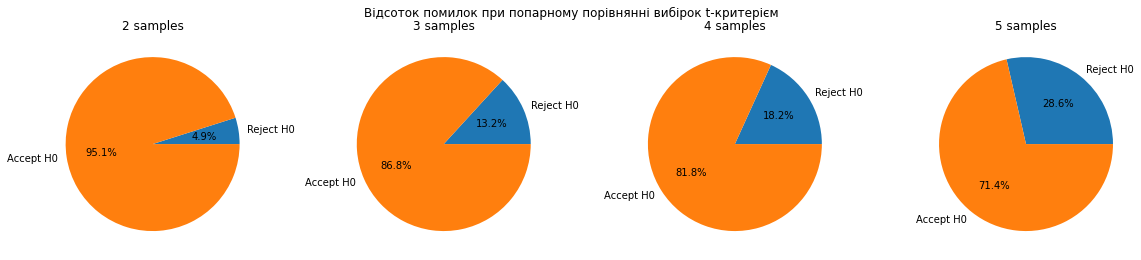

In [30]:
def get_result_ttest(group_count, alpha):
    # Для того щоб подивитись скільки помилкових результатів ми отримаємо при множинних міжгрупових
    # порівнянях підрахуємо кількість відхилених та прийнятих  нульових гіпотез при 
    # дослідженні певної кількості group_count
    result_ttest = {'Reject H0':0, 'Accept H0':0}
    #сформуємо такий список даних із цих груп
    samples = []
    for i in range(group_count):
        sample = stats.norm.rvs(loc=5.5, scale=0.5, size=10)
        samples.append(sample)
    #за допомогою бібліотеки itertools сформуємо та перевіримо на відмінність можливі комбінації
    #для даних груп    
    for first, second in itertools.combinations(samples, 2):
        result = stats.ttest_ind(first, second)
        if result.pvalue < alpha:
            result_ttest['Reject H0'] += 1
        else:
            result_ttest['Accept H0'] += 1
    #розрахуємо відсоток отриманих помилок
    error = round(result_ttest['Reject H0'] / (result_ttest['Reject H0']+result_ttest['Accept H0']),3)
    if error != 0:
        return {'Reject H0':1, 'Accept H0':0}
    else:
        return {'Reject H0':0, 'Accept H0':1}

# Повторимо наш експеримент 1000 разів та розрахуємо відсоток помилково прийянятої альтернативної гіпотези   
def ploting_pie(group, ax, alpha = 0.05):
    counter = collections.Counter()
    for i in range(1000):
        counter.update(get_result_ttest(group, alpha))
    result_ttest = dict(counter)
    ax.pie([float(result_ttest[v]) for v in result_ttest], labels=[str(k) for k in result_ttest], autopct='%1.1f%%')


fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
n_samples = [2, 3, 4, 5]
fig.suptitle('Відсоток помилок при попарному порівнянні вибірок t-критерієм')


for n, ax in zip(n_samples, axs):
    ploting_pie(n, ax)
    ax.set_title(f'{n} samples')

Як видно з графіків для порівняння 2х груп помилка виявляється приблизно в 4.9% випадків тоді як зі збільшенням числа порівнюваних груп збільшується дана помилка. Так порівнюючи 5 груп помилкові твердження приймаються у 28.6% в експерименті та 22.62% за розрахунками.

У такій ситуації необхідно застосовувати менший критичний рівень значущості, який розраховується за такою <a href='#part2'>формулою</a>:

$p^* = \frac{(1 – 0,95)}{n}$

де, $p^*$ - критичний рівень значущості для множинних порівнянь, n - кількість виконаних порівнянь

Для прикладу попарних порівнянь 3х вибірок p* становитиме (1 – 0,9)/3 = 0,0166, тобто різницю між групами вважатимуться статистично значимими, тільки якщо p < 0,0166. 

З цього випливає, що в публікаціях, де зустрічається $p(1-2) < 0,05, p(2-3) > 0,05, p(1-3) > 0,05$ абсолютно неможливо зробити висновок про статистичну значущість відмінностей між групами 1 і 2, а тому варто з обережністю ставитися до інтерпретації відповідних даних.
[посилання на статтю](https://lit-review.ru/biostatistika/mnozhestvennye-sravneniya/)

<p id='part2'></p> <p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #0099FF; line-height:1.3">Поправка Бонферроні</p>

У статистиці поправка <a href='https://en.wikipedia.org/wiki/Bonferroni_correction'>Бонферроні</a> є методом протидії проблемі численних порівнянь. Корекція Бонферроні – найпростіший спосіб протидії цьому; проте це консервативний метод, який дає більший ризик відмови відхилити помилкову нульову гіпотезу, ніж інші методи, оскільки він ігнорує потенційно цінну інформацію, таку як розподіл p-значень за всіма порівняннями (які, якщо нульова гіпотеза вірна для всіх порівнянь, очікується рівномірний розподіл ).
Поправка Бонферроні розраховується за даними попередньої $\alpha$ розділених на кількість парних <a  href='https://uk.wikipedia.org/wiki/Комбінація_(комбінаторика)'> комбінацій </a> з кількості досліджуваних груп

$$ \text{new } \alpha = \frac{\alpha}{\frac {n!}{k!(n-k)!}}$$

де, n - кількість порівнюваних вибірок, k = 2 тобто порівнюються 2 групи між собою

In [14]:
alpha = 0.05
combination = lambda n, k: math.factorial(n)/(math.factorial(k)*math.factorial(n-k))
Bonferroni_correction = alpha/combination(8,2)
Bonferroni_correction

0.0017857142857142859

Проведемо аналогічний експеримент з застосуванням зазначеної поправки Бенферроні

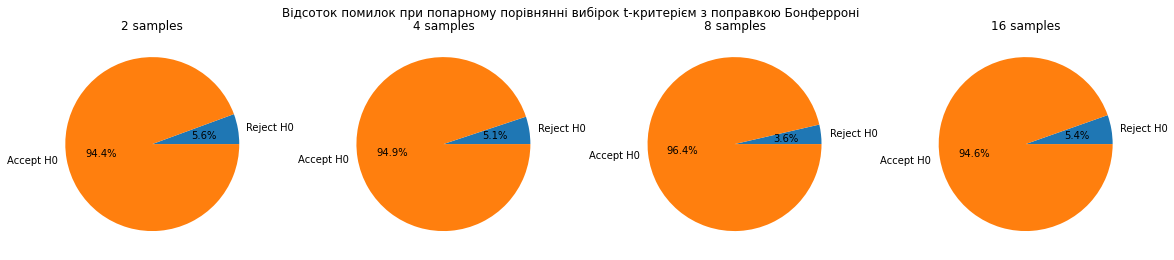

In [33]:
# Повторим наш експеримент 1000 разів та розрахуємо відсоток помилково прийянятої альтернативної гіпотези   
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
n_samples = [2, 4, 8, 16]
fig.suptitle('Відсоток помилок при попарному порівнянні вибірок t-критерієм з поправкою Бонферроні')

for n, ax in zip(n_samples, axs):
    alpha = 0.05/combination(n,2)
    ploting_pie(n, ax, alpha)
    ax.set_title(f'{n} samples')

Після застосування поправки Бонферроні було отримано в усіх випадках помилку яка не перевищує 5.6% Поправка Бонферроні добре контролює помилку 1 типу, але є дуже консервативною і призводить до підвищення ймовірності помилки 2 типу (ймовірності прийняття рішення про відсутність відмінностей там, де вони насправді є).

Ліберальні критерії, (наприклад критерій Тьюкі, Tukey's honestly significant difference test або **Tukey's HSD test**) у свою чергу, завищують ймовірність помилки 1 типу, тобто ймовірність ухвалення рішення про наявність відмінностей там, де їх немає.

Таким чином, при виборі статистичного критерію для апостеріорних порівнянь необхідно брати до уваги, як критерії контролюють помилки 1 і 2 типів та як вони працюють при недотриманні необхідних умов застосування дисперсійного аналізу.

http://mathhelpplanet.com/viewtopic.php?f=37&t=71666&sid=7e4d8436062666f46d887ef66fe87284

<p id='part3'></p> <p style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 2px; color: #0099FF; line-height:1.3">Критерій множинних порівнянь Тьюкі</p>

[Критерій Тьюкі](https://r-analytics.blogspot.com/2013/10/blog-post_19.html) є модифікованим критерієм Стьюдента:
$$q = \frac{\bar{x}_B - \bar{x}_A}{SE}$$

Відмінність від критерію Стьюдента у тому, як розраховується стандартна помилка $SE$:

$$SE = \sqrt{\frac{MSw}{n}}$$

де $MSw$ це внутрішньогрупова дисперсія, що розраховується в ході [дисперсійного аналізу](https://r-analytics.blogspot.com/2013/01/blog-post.html) (ANOVA).

$$MSw = \frac{SSW}{dfSSW}$$

Наведена формула для критерію Тьюкі правильна для випадків, коли всі порівнювані групи містять однакову кількість спостережень n. Якщо порівнювані групи неоднакові за розміром, стандартна помилка розраховуватиметься так:

$$SE = \sqrt{\frac{MSw}{2}(\frac{1}{n_A}+\frac{1}{n_B})}$$

Проведемо розрахунки до завдання з дисперсійного аналізу для якого потрібно було перевірити чи є відмінності терапії A, B, C, D Результати дослідження представлені у [таблиці](https://stepik.org/media/attachments/lesson/8083/genetherapy.csv)

In [5]:
URL = 'https://stepik.org/media/attachments/lesson/8083/genetherapy.csv'
data = pd.read_csv(URL)
lm = ols('expr ~ Therapy', data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
Therapy,3.0,560.716667,186.905556,8.037302,0.000152
Residual,56.0,1302.266667,23.254762,NaN,NaN


In [11]:
SSW = 1302.266667
MSw = 23.254762
data.groupby('Therapy').count().T

Therapy,A,B,C,D
expr,15,15,15,15


In [67]:
SE = math.sqrt(MSw/15) #Out: 1.2451174509525864

In [19]:
combinations = list(itertools.combinations(data.Therapy.unique(), 2))

In [101]:
from scipy.stats import studentized_range

n_group = len(data.Therapy.unique()) # Кількість груп у виборці
dfSSW = len(data.expr) - len(data.Therapy.unique()) # внутрішньогрупові ступені свободи: n-m

#Знаходження довірчих інтервалів провадиться за формулою (Xa - Xb) +/- q_crit*SE
alpha = 0.05
q_crit = studentized_range.ppf(1-alpha, n_group, dfSSW) # Out: 3.7446781868177195

df = pd.DataFrame(columns=[f'{first} - {second}' for first, second in combinations], 
                 index=['q','meandiff','p-adj','lower','upper'])

means = data.groupby('Therapy').mean().T

for first, second in combinations: #first, second
    key = f'{first} - {second}'
    first_second_mean = [means[first].expr, means[second].expr]
    _q = (max(first_second_mean) - min(first_second_mean))/SE
    _meandiff = (means[second].expr - means[first].expr)
    df[key]['q'] = _q
    df[key]['meandiff'] = _meandiff
    df[key]['p-adj'] = 1-studentized_range.cdf(_q, n_group, dfSSW)
    df[key]['upper'] = _meandiff+ q_crit*SE
    df[key]['lower'] = _meandiff- q_crit*SE

df.T

,q,meandiff,p-adj,lower,upper
A - B,0.749595,-0.933333,0.95142,-5.595897,3.729231
A - C,4.283398,-5.333333,0.018886,-9.995897,-0.670769
A - D,5.943214,-7.4,0.000542,-12.062564,-2.737436
B - C,3.533803,-4.4,0.071041,-9.062564,0.262564
B - D,5.19362,-6.466667,0.002944,-11.129231,-1.804103
C - D,1.659817,-2.066667,0.645794,-6.729231,2.595897


In [35]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

data_stepik = pd.read_csv('https://stepik.org/media/attachments/lesson/8083/genetherapy.csv')
MultiComp = MultiComparison(data_stepik['expr'], data_stepik['Therapy'])
MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.9333,0.9514,-5.5959,3.7292,False
A,C,-5.3333,0.0189,-9.9959,-0.6708,True
A,D,-7.4,0.0005,-12.0626,-2.7374,True
B,C,-4.4,0.071,-9.0626,0.2626,False
B,D,-6.4667,0.0029,-11.1292,-1.8041,True
C,D,-2.0667,0.6458,-6.7292,2.5959,False


Text(0.5, 1.0, '95% family-wise confidence level')

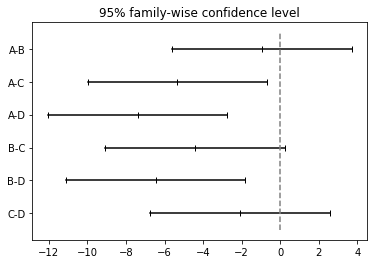

In [37]:
data = MultiComp.tukeyhsd()._results_table.data
df = pd.DataFrame(data[1:], columns=data[0])

df['category'] = df['group1'] + ['-'] * len(df) + df['group2']
df['orderby'] = range(len(df), 0, -1)

for lower, upper, meandiff, y in zip(df['lower'], df['upper'], df['meandiff'], df['orderby']):
    plt.plot((lower, upper),(y, y), '|-', color='black')
    plt.plot(meandiff, y ,'|-', color='black')
    
plt.yticks(df['orderby'], df['category'])
plt.vlines(0, df['orderby'].min() - 0.5, df['orderby'].max() + 0.5, linestyles='dashed', color='gray')
plt.title('95% family-wise confidence level')

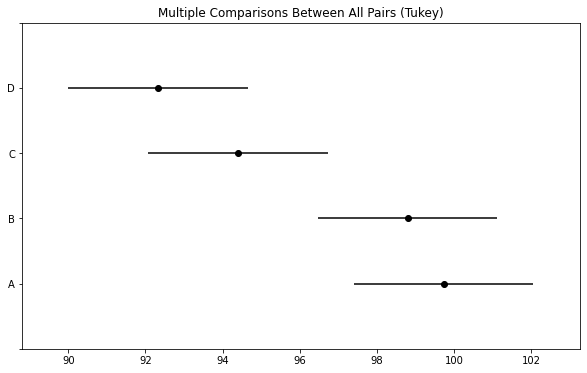

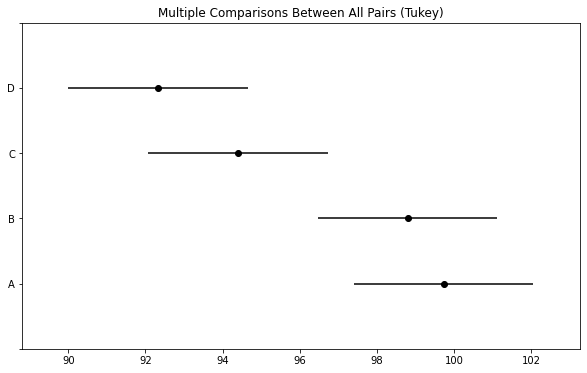

In [102]:
MultiComp.tukeyhsd().plot_simultaneous()